In [2]:
import numpy as np 
from numba import njit
import matplotlib.pyplot as plt 
from matplotlib import cm 
from matplotlib import animation 
from IPython.display import HTML 

from os import listdir
from os.path import abspath, isfile, join
from matplotlib import pyplot as plt
import sys
sys.path.append("../")
from taco import Optimizer, Oracle, ToyProblem
import numpy as np
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm

from scipy.optimize import line_search, minimize

<a id='main_plan'></a>
# Implementation of the scenario generation approach for chance constraints

**Goal**: Implement on the 2D quadratic problem the chance constraint generation approaach. 

- Step 1: Fetch code for the problem and plot all contour lines.
- [Step 2](#step2): Solve a scenario problem with the right number of scenarios.
- Step 3: Plot the solution of the problem for different instances generated. 

In [3]:
nb_samples = 50000

def generate_data(nb_samples=10000):
    np.random.seed(42)
    mean = np.array([1.0, 1.0])
    cov = 30 * np.eye(2)
    data = np.random.multivariate_normal(mean, cov, size=nb_samples)
    data = np.asarray(data, dtype=np.float64)
    return data

problem = ToyProblem(generate_data(nb_samples), generate_data(nb_samples=10))

In [4]:
proba_thresh = 0.008
params = {
                'p': proba_thresh,
                'nb_iterations': 100,
                'starting_point': np.array([ 0.5, 1.5, 0.01], dtype=np.float64),
    
                'pen1': 400.0,
                'pen2': 600.0,
                'pen_factor': 10.,

                'bund_kappa': 0.0001,
                'bund_mu_start': 38.0,
                'bund_mu_low': 0.001,
                'bund_mu_high': 1000.0,
                'bund_delta_tol': 0.00001,
                'bund_scaling_term': 1.0,
                'bund_restarting_period': 100,
                'bund_mu_restart': 15.0,
                'bund_mu_inc': 1.05,
                'bund_mu_dec': 0.9,
                'bund_epsilon_alpha': 0.01,
                'bund_max_size_bundle_set': 15,

                'bund_restarting_penalty_slack': 0.0001,
                'bund_restarting_epsilon_eta': 0.00001,
                'superquantile_smoothing_param': 0.001,
                'numba': True
    }

x_min = 0.0
x_max = 5.0
y_min = 0.0
y_max = 5.0

@njit
def mean_G(problem, x):
    xi = problem.data
    n = len(problem.data)
    res = 0.0
    for ii in range(n):
        if problem.constraint_func(x, xi[ii]) <= 0.0:
            res += 1.0
    return res/n

@njit
def create_grid(problem):
    X_1 = np.linspace(x_min, x_max, 40)
    Y_1 = np.linspace(y_min, y_max, 40)
    Z_1 = np.zeros((len(X_1),len(Y_1)))
    Z_2 = np.zeros((len(X_1),len(Y_1)))
    for i in range(len(X_1)):
        for j in range(len(Y_1)):
            u = np.array([X_1[i], Y_1[j]], dtype=np.float64)
            Z_1[j][i] = problem.objective_func(u)
            Z_2[j][i] = mean_G(problem, u)
    return Z_1, Z_2

X_1 = np.linspace(x_min, x_max, 40)
Y_1 = np.linspace(y_min, y_max, 40)
Z_1, Z_2 = create_grid(problem)

<ipython-input-4-933e76b2b235>:55: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  Z_2[j][i] = mean_G(problem, u)
<ipython-input-4-933e76b2b235>:55: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, C), array(float64, 1d, A))
  Z_2[j][i] = mean_G(problem, u)
<ipython-input-4-933e76b2b235>:55: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  Z_2[j][i] = mean_G(problem, u)


In [5]:
optimizer = Optimizer(problem, params=params)
optimizer.run(verbose=True, logs=True)

array([32.16238197,  3.0055559 , -7.47782459])

<a id='step2'></a>
### Step 2 : Solve a scenario problem with the right number of scenarios

The paper is Uncertain convex programs: randomized solutions and
confidence levels, by Calafiore and Campi (2005).

Link : https://staff.polito.it/giuseppe.calafiore/Documenti/Papers/Uncertain%20Convex%20programs_MP-05.pdf

In view of their Theorem 1 and their discussion in Section 4.3. We need to take a number of data points $N$ that satisfies:
$$N \geq \frac{n}{\varepsilon \beta} - 1$$.

where 
 - $n$ is the dimension of the decision vector. Here it is $n=2$.
 - $\varepsilon$ is the target probability of failure. In our case it is $\varepsilon = 1-p_{thresh} = 1-0.008 = 0.992$.
 - $\beta$ is a probability for the output decision to be true. Take $\beta = 10^{-4}$.  
 
- Step 2.1 : Implement a the minimizization of the penalized objective using BFGS.
- [Step 2.2](#step2.2): Observe graphically the solving of the scenario generated problem.
- [Step 2.3](#step2.3): Plot the heatmap of the probability function and add a colorbar.
- [Step 2.4](#step2.4): Implement the problem from the eventual convexity paper and add a quadratic.
- [Step 2.5](#step2.5): Solve the problem using TACO.

**Step 2.1** : Implement a the minimizization of the penalized objective using BFGS.

In [6]:
# Vectorized constraint function
@njit
def vec_const_obj(x, problem):
    s = len(problem.data)
    res = np.zeros(s)
    for ii in range(s):
        res[ii] = problem.constraint_func(x, problem.data[ii])
    return res

# Vectorized constraint gradient
@njit
def vec_const_grad(x, problem):
    s = len(problem.data)
    res = np.zeros((s, len(x)), dtype=np.float64)
    for ii in range(s):
        res[ii] = problem.constraint_grad(x, problem.data[ii])
    return res

# Penalized Oracle
@njit
def pen_obj(x, lmbda, problem):
    constraints = vec_const_obj(x, problem)
    s = len(problem.data)
    return problem.objective_func(x) + 0.5 * lmbda / s * np.sum(np.square(np.maximum(0, constraints)))

# Penalized Oracle Gradient
@njit
def pen_grad(x, lmbda, problem):
    constraints = vec_const_obj(x, problem)
    constraints_grads = vec_const_grad(x, problem)
    res = problem.objective_grad(x)
    s = len(problem.data)
    for ii in range(len(constraints_grads)):
        if constraints[ii] > 0:
            res += lmbda / s * constraints[ii] * constraints_grads[ii]
    return res

In [7]:
# Implementation of BFGS

class LoggedOracle(object):

    def __init__(self, oracle):

        self.oracle = oracle
        self.nb_calls = 0

    def __call__(self, w):
        self.nb_calls += 1
        return self.oracle(w)

class LBFGS:
    
    def __init__(self, fun, grad, w_start, obj_fun, proba_fun):
        self.fun = fun
        self.grad = grad
        
        self.proba_fun = obj_fun
        self.proba_fun = proba_fun
        
        self.list_iterates = []
        self.list_values = []
    
        self.w_start = w_start
        self.solution = None
        self.bfgs_result_object = None

        self.tot_nb_fun_eval = 0
        self.tot_nb_grad_eval = 0
        self.nb_fun_eval = []
        self.nb_grad_eval = []
        self.counter = 0
        
        self.obj_vals = []
        self.proba_vals = []
        
    def run(self, logs=False, verbose_mode=False, logs_freq=1):
        
        f = LoggedOracle(self.fun)
        g = LoggedOracle(self.grad)
        
        def callback(x_k):
            if verbose_mode:
                sys.stdout.write('%d iterations completed \r' % self.counter)
                sys.stdout.flush()
            if logs and self.counter % logs_freq == 0:
                self.nb_fun_eval.append(f.nb_calls)
                self.nb_grad_eval.append(g.nb_calls)                
                self.list_values.append(self.fun(x_k))
                self.list_iterates.append(x_k)
                self.obj_vals.append(self.obj_fun(x_k))
                self.proba_vals.append(self.proba_vals(x_k))

            if verbose_mode or logs:
                self.counter += 1
        
        minimizing_options = {
            'disp': None,
            'maxcor': 100,
            'ftol': 2.220446049250313e-12,
            'gtol': 1e-12,
            'eps': 1e-08,
            'maxfun': 100000,
            'maxiter': 100000,
            'iprint': -1,
            'maxls': 10  # 10
        }
        
        result_object = minimize(f, self.w_start, jac=g, method='L-BFGS-B', callback=callback, options=minimizing_options)

        self.bfgs_result_object = result_object

        self.tot_nb_fun_eval = result_object.nfev
        self.tot_nb_grad_eval = result_object.nfev
        
        self.w = result_object.x
        
def run_lbfgs(lmbda, problem):
    
    def pen_f(x):
        return pen_obj(x, lmbda, problem)
    def pen_g(x):
        return pen_grad(x, lmbda, problem)
    
    def obj_fun(x):
        return problem.objective_func(x)
    def proba_fun(x):
        return mean_G(problem, x)
    
    algo = LBFGS(f, g, np.zeros(2))
    algo.run(logs=True, verbose_mode=True)
    return algo.list_iterates, algo.list_values

<a id='step2.2'></a>

**Step 2.2**: Observe graphically the solving of the scenario generated problem.

   - Step 2.2.1: instantiate a problem with the right number of scenarios.
   - Step 2.2.2: implement a function that checks weather a given point satisfies all the scenario constraints.
   - Step 2.2.3: Plot two regions in green and blue, that are feasible and not feasible for the generated problem.

[Back to step 2](#step2)

In [10]:
# Step 2.2.1
n_scenarios = int(2./(0.992 * 1e-3) - 1)
scenario_problem = ToyProblem(generate_data(nb_samples=n_scenarios), generate_data(2))

# Step 2.22
# @njit
def constraint_checker(problem, x):
    for ii in range(len(problem.data)):
        if problem.constraint_func(x, problem.data[ii]) > 0:
#             print(x)
#             print(problem.data[ii])
            return False
    return True

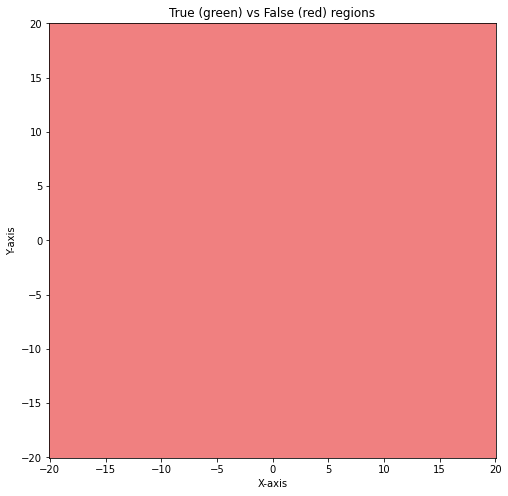

In [11]:
# Step 2.2.3
# Create a function to evaluate the grid
def evaluate_grid(X, Y, func):
    Z = np.empty_like(X, dtype=bool)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = func(np.array([X[i, j], Y[i, j]], dtype=np.float64))
    return Z

# Generate a grid of points
x = np.linspace(-20, 20, 400)  # Adjust the range and resolution as needed
y = np.linspace(-20, 20, 400)
X, Y = np.meshgrid(x, y)

Z = evaluate_grid(X, Y, lambda x :constraint_checker(scenario_problem, x))

# Plot the regions
plt.figure(figsize=(8,8))
plt.pcolormesh(X, Y, Z, shading='auto', cmap=ListedColormap(['lightcoral', 'lightgreen']))
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("True (green) vs False (red) regions")
plt.show()

As we can see above, there is no feasibility region for the sampled problem. Let's see below what are the levels sets of the probability levels of the sampled problem. 

In [12]:
X_1 = np.linspace(x_min, x_max, 40)
Y_1 = np.linspace(y_min, y_max, 40)
Z_1_sampled, Z_2_sampled = create_grid(scenario_problem)

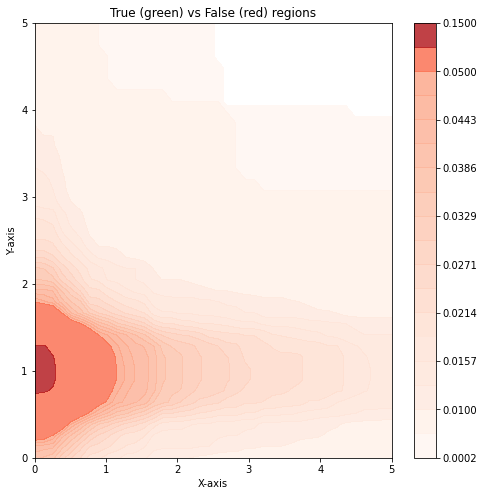

In [13]:
# Plot the regions
plt.figure(figsize=(8,8))

red_levels = np.linspace(0.01, 0.05, 15)
full_red_levels = [0.0002, 0.0005] + list(red_levels) + list(np.linspace(0.1, 0.15, 2))
plt.contourf(X_1, Y_1, Z_2_sampled, cmap=cm.Reds, alpha=0.8, levels=full_red_levels)
plt.colorbar()
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("True (green) vs False (red) regions")
plt.show()

The probability function of the sampled problem does not go beyond 0.15: we can't expect to get a feasible for this sampled problem.